In [103]:
import boto3
import pandas as pd
import glob
import os
import time
from sagemaker import get_execution_role
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from botocore.exceptions import ClientError

# sklearn imports
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    HistGradientBoostingRegressor
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
from sklearn.model_selection import (
    cross_val_score,
    TimeSeriesSplit,
    RandomizedSearchCV
)

import xgboost as xgb  

role = get_execution_role()

In [44]:
print(role)

arn:aws:iam::952406520242:role/service-role/AmazonSageMaker-ExecutionRole-20250730T173361


In [45]:
bucket = "mypollutionanalysisbucket"
data_location = 's3://{}/raw/Data/'.format(bucket)

In [46]:
pd.read_csv(data_location+"city_data/GJ001.csv")

,file_name,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),SO2 (ug/m3),CO (mg/m3),...,O Xylene (ug/m3),RH (%),WS (m/s),WD (deg),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),Xylene (ug/m3),RF (mm)
0,GJ001,2010-11-11 17:00:00,2010-11-11 18:00:00,NaN,NaN,NaN,74.88,73.91,19.61,0.23,...,NaN,43.06,1.10,NaN,17.04,987.44,0.20,29.53,0.0,NaN
1,GJ001,2010-11-11 18:00:00,2010-11-11 19:00:00,NaN,NaN,0.01,81.46,80.76,16.44,0.61,...,NaN,45.53,1.01,NaN,0.43,991.42,0.20,28.75,0.0,NaN
2,GJ001,2010-11-11 19:00:00,2010-11-11 20:00:00,NaN,NaN,3.02,100.24,103.25,16.05,1.10,...,NaN,46.99,0.34,NaN,0.41,995.56,0.20,28.37,0.0,NaN
3,GJ001,2010-11-11 20:00:00,2010-11-11 21:00:00,NaN,NaN,33.57,126.11,159.68,19.01,2.30,...,NaN,49.02,0.07,158.76,0.42,998.19,0.20,27.71,0.0,NaN
4,GJ001,2010-11-11 21:00:00,2010-11-11 22:00:00,NaN,NaN,100.24,171.96,272.20,21.55,3.72,...,NaN,51.45,0.07,122.88,0.42,999.59,0.20,27.26,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108554,GJ001,2023-03-31 19:00:00,2023-03-31 20:00:00,20.45,44.64,10.41,102.14,57.59,18.18,2.38,...,NaN,48.02,4.38,253.78,255.97,800.00,0.85,29.42,NaN,NaN
108555,GJ001,2023-03-31 20:00:00,2023-03-31 21:00:00,38.38,50.54,6.85,50.20,29.60,36.76,0.80,...,NaN,72.70,8.69,228.75,258.20,800.00,0.89,24.54,NaN,NaN
108556,GJ001,2023-03-31 21:00:00,2023-03-31 22:00:00,30.14,65.81,6.27,51.15,29.63,9.46,0.78,...,NaN,79.81,6.76,230.00,261.25,800.00,0.73,23.24,NaN,NaN
108557,GJ001,2023-03-31 22:00:00,2023-03-31 23:00:00,23.32,51.77,7.06,58.04,33.58,2.49,1.77,...,NaN,60.20,5.27,229.71,256.75,800.00,0.55,4.81,NaN,NaN


In [47]:
df_states = pd.read_csv(f'{data_location}station/stations_info.csv')
df_states.drop(columns=['agency','station_location','start_month'],inplace=True)

In [48]:
df_states

,file_name,state,city,start_month_num,start_year
0,AP001,Andhra Pradesh,Tirupati,7,2016
1,AP002,Andhra Pradesh,Vijayawada,5,2017
2,AP003,Andhra Pradesh,Visakhapatnam,7,2017
3,AP004,Andhra Pradesh,Rajamahendravaram,9,2017
4,AP005,Andhra Pradesh,Amaravati,11,2017
...,...,...,...,...,...
448,WB010,West Bengal,Howrah,5,2019
449,WB011,West Bengal,Kolkata,6,2019
450,WB012,West Bengal,Kolkata,8,2019
451,WB013,West Bengal,Kolkata,8,2019


In [49]:
import boto3
import pandas as pd
from botocore.exceptions import ClientError

def combine_state_df(state_name):
    try:
        # Initialize S3 client
        s3 = boto3.client('s3')
        bucket = 'mypollutionanalysisbucket'
        prefix = 'raw/Data/city_data/'  # Your folder path within bucket
        
        # Get state code
        state_row = df_states[df_states['state'] == state_name]
        if state_row.empty:
            raise ValueError(f"State '{state_name}' not found in df_states")
            
        state_code = state_row['file_name'].iloc[0][:2]
        print(f"Looking for files with prefix: {prefix}{state_code}")
        
        # List objects in S3
        response = s3.list_objects_v2(
            Bucket=bucket,
            Prefix=f"{prefix}{state_code}"
        )
        
        # Check if files were found
        if 'Contents' not in response:
            raise FileNotFoundError(f"No files found in s3://{bucket}/{prefix}{state_code}*")
            
        # Filter for CSV files
        state_files = [
            obj['Key'] for obj in response['Contents']
            if obj['Key'].endswith('.csv')
        ]
        
        print(f"Found {len(state_files)} files:")
        for file in state_files:
            print(f"- {file}")
            
        if not state_files:
            raise ValueError("No CSV files found matching criteria")
            
        # Process files
        combined_dfs = []
        
        for file_key in state_files:
            try:
                # Get object from S3
                obj = s3.get_object(Bucket=bucket, Key=file_key)
                file_df = pd.read_csv(obj['Body'])
                
                # Extract filename without path/extension
                file_name = file_key.split('/')[-1].replace('.csv', '')
                
                # Add city information
                city_match = df_states[df_states['file_name'] == file_name]
                if not city_match.empty:
                    file_df['city'] = city_match['city'].values[0]
                    combined_dfs.append(file_df)
                else:
                    print(f"Warning: No city found for {file_name}")
                    
            except Exception as e:
                print(f"Error processing {file_key}: {str(e)}")
                continue
                
        if not combined_dfs:
            raise ValueError("No valid DataFrames processed")
            
        return pd.concat(combined_dfs, ignore_index=True)
        
    except ClientError as e:
        print(f"S3 Access Error: {str(e)}")
        print("Check if your SageMaker role has s3:GetObject permissions")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error: {str(e)}")
        return pd.DataFrame()

In [50]:
df = combine_state_df("Delhi")

Looking for files with prefix: raw/Data/city_data/DL
Found 40 files:
- raw/Data/city_data/DL001.csv
- raw/Data/city_data/DL002.csv
- raw/Data/city_data/DL003.csv
- raw/Data/city_data/DL004.csv
- raw/Data/city_data/DL005.csv
- raw/Data/city_data/DL006.csv
- raw/Data/city_data/DL007.csv
- raw/Data/city_data/DL008.csv
- raw/Data/city_data/DL009.csv
- raw/Data/city_data/DL010.csv
- raw/Data/city_data/DL011.csv
- raw/Data/city_data/DL012.csv
- raw/Data/city_data/DL013.csv
- raw/Data/city_data/DL014.csv
- raw/Data/city_data/DL015.csv
- raw/Data/city_data/DL016.csv
- raw/Data/city_data/DL017.csv
- raw/Data/city_data/DL018.csv
- raw/Data/city_data/DL019.csv
- raw/Data/city_data/DL020.csv
- raw/Data/city_data/DL021.csv
- raw/Data/city_data/DL022.csv
- raw/Data/city_data/DL023.csv
- raw/Data/city_data/DL024.csv
- raw/Data/city_data/DL025.csv
- raw/Data/city_data/DL026.csv
- raw/Data/city_data/DL027.csv
- raw/Data/city_data/DL028.csv
- raw/Data/city_data/DL029.csv
- raw/Data/city_data/DL030.csv
-

In [51]:
df.head()

,file_name,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),...,Benzene (),SR (),Temp (ug/m3),WD (),SO2 (),RH (),BP (),Eth-Benzene (),Xylene (),CH4 ()
0,DL001,2010-01-01 00:00:00,2010-01-01 01:00:00,NaN,NaN,21.02,41.00,38.75,NaN,4.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DL001,2010-01-01 01:00:00,2010-01-01 02:00:00,NaN,NaN,9.12,29.50,23.25,NaN,4.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DL001,2010-01-01 02:00:00,2010-01-01 03:00:00,NaN,NaN,10.48,27.25,23.25,NaN,4.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DL001,2010-01-01 03:00:00,2010-01-01 04:00:00,NaN,NaN,6.50,24.25,18.25,NaN,4.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DL001,2010-01-01 04:00:00,2010-01-01 05:00:00,NaN,NaN,5.75,21.50,16.25,NaN,4.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# Make the 'From Date' column the index as datetime
def create_dt_index(dataframe):
    dataframe = dataframe.drop(columns='To Date')
    dataframe['From Date'] = pd.to_datetime(dataframe['From Date'])
    dataframe = dataframe.rename(columns={'From Date': 'datetime'})
    return dataframe.set_index('datetime')

In [53]:
df = create_dt_index(df)
df.head()

,file_name,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),...,Benzene (),SR (),Temp (ug/m3),WD (),SO2 (),RH (),BP (),Eth-Benzene (),Xylene (),CH4 ()
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,DL001,NaN,NaN,21.02,41.00,38.75,NaN,4.27,4.43,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 01:00:00,DL001,NaN,NaN,9.12,29.50,23.25,NaN,4.55,3.69,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 02:00:00,DL001,NaN,NaN,10.48,27.25,23.25,NaN,4.62,3.68,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 03:00:00,DL001,NaN,NaN,6.50,24.25,18.25,NaN,4.52,3.11,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 04:00:00,DL001,NaN,NaN,5.75,21.50,16.25,NaN,4.70,2.80,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
import os

def plot_feature_similarities(dataframe, feature_groups, columns=2, output_dir='feature_groups'):
    """
    Plots feature similarities and exports each group to CSV
    
    Parameters:
    - dataframe: Input DataFrame with time series data
    - feature_groups: Dictionary of {group_name: [features]}
    - columns: Number of columns in subplot grid
    - output_dir: Directory to save CSV files (default: 'feature_groups')
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # First ensure we have a datetime index
    if not isinstance(dataframe.index, pd.DatetimeIndex):
        try:
            dataframe = dataframe.copy()
            dataframe.index = pd.to_datetime(dataframe.index)
            print("Converted index to datetime")
        except Exception as e:
            print(f"Could not convert index to datetime: {str(e)}")
            return
    
    # Calculate rows needed
    rows = int(np.ceil(len(feature_groups) / columns))
    
    # Create subplots
    fig, axes = plt.subplots(rows, columns, figsize=(13, 4*rows))
    if rows == 1 and columns == 1:
        axes = np.array([[axes]])
    elif rows == 1 or columns == 1:
        axes = axes.reshape(rows, columns)
    fig.tight_layout(pad=3.0)
    
    axes_flat = axes.flatten()
    
    for ax, (group_name, features) in zip(axes_flat, feature_groups.items()):
        # Verify features exist
        valid_features = [f for f in features if f in dataframe.columns]
        missing_features = set(features) - set(valid_features)
        
        if missing_features:
            print(f"Warning: Missing features in group '{group_name}': {missing_features}")
        
        if not valid_features:
            ax.set_title(f"{group_name} (No valid features)")
            ax.axis('off')
            continue
            
        # Create DataFrame for this group's CSV
        group_df = pd.DataFrame(index=dataframe.index)
        
        # Plot each valid feature
        lines = []  # To store line objects for legend
        for feature in valid_features:
            try:
                # Get non-null values and group by year
                valid_data = dataframe[dataframe[feature].notnull()][feature]
                yearly_avg = valid_data.groupby(valid_data.index.year).mean()
                
                # Plot and store line for legend
                line = sns.lineplot(data=yearly_avg, label=feature, ax=ax)
                lines.append(line)
                
                # Add to group DataFrame
                group_df[feature] = dataframe[feature]
                
            except Exception as e:
                print(f"Error plotting {feature}: {str(e)}")
                continue
                
        # Save group data to CSV
        csv_filename = f"{group_name.replace(' ', '_').lower()}_group.csv"
        csv_path = os.path.join(output_dir, csv_filename)
        group_df.to_csv(csv_path)
        print(f"Saved {group_name} data to {csv_path}")
                
        ax.set_title(group_name)
        ax.set_xlabel('Year')
        if lines:  # Only add legend if we have lines
            ax.legend()
        else:
            ax.axis('off')
    
    # Hide unused axes
    for ax in axes_flat[len(feature_groups):]:
        ax.axis('off')
    
    plt.show()

Saved Xylene data to feature_groups/xylene_group.csv
Saved MP-Xylene data to feature_groups/mp-xylene_group.csv
Saved Wind Direction data to feature_groups/wind_direction_group.csv
Saved Ozone data to feature_groups/ozone_group.csv
Saved Nitrogen Oxides data to feature_groups/nitrogen_oxides_group.csv
Saved Relative Humidity data to feature_groups/relative_humidity_group.csv
Saved Solar Radiation data to feature_groups/solar_radiation_group.csv
Saved Air Temperature data to feature_groups/air_temperature_group.csv


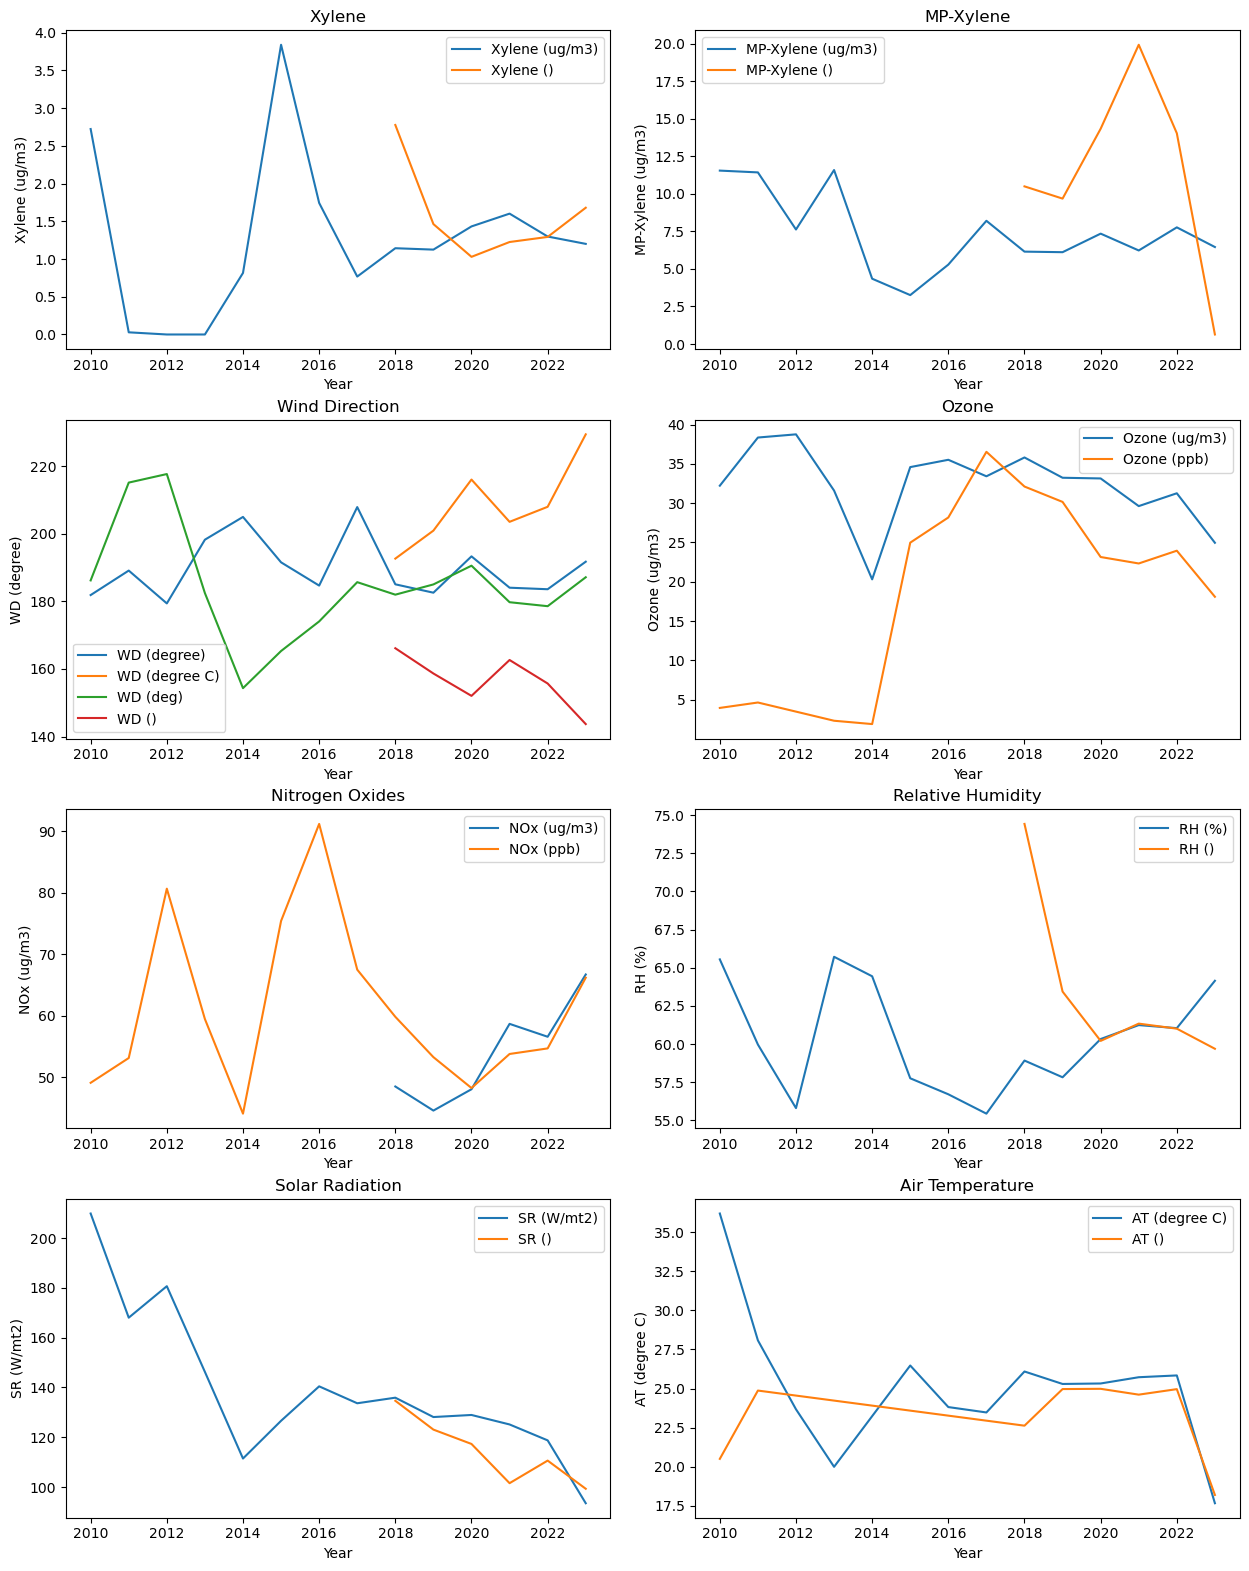

In [55]:
groups = {
    'Xylene':            ['Xylene (ug/m3)', 'Xylene ()'],
    "MP-Xylene":         ['MP-Xylene (ug/m3)', 'MP-Xylene ()'],
    'Wind Direction':    ["WD (degree)", "WD (degree C)", "WD (deg)", "WD ()"],
    'Ozone':             ['Ozone (ug/m3)', 'Ozone (ppb)'],
    'Nitrogen Oxides':   ['NOx (ug/m3)', 'NOx (ppb)'],
    'Relative Humidity': ['RH (%)', 'RH ()'],
    'Solar Radiation':   ['SR (W/mt2)', 'SR ()'],
    'Air Temperature':   ['AT (degree C)', 'AT ()']
}

plot_feature_similarities(df, groups, columns=2)

In [56]:
all_groups = [item for sublist in list(groups.values()) for item in sublist]
df[all_groups].describe().applymap(lambda x: f"{x:0.3f}")

/tmp/ipykernel_9553/975514156.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[all_groups].describe().applymap(lambda x: f"{x:0.3f}")


,Xylene (ug/m3),Xylene (),MP-Xylene (ug/m3),MP-Xylene (),WD (degree),WD (degree C),WD (deg),WD (),Ozone (ug/m3),Ozone (ppb),NOx (ug/m3),NOx (ppb),RH (%),RH (),SR (W/mt2),SR (),AT (degree C),AT ()
count,242944.000,34578.000,264768.000,29205.000,813361.000,43888.000,655812.000,122463.000,1874697.000,47576.000,86086.000,1876466.000,1611483.000,39722.000,1555347.000,43267.000,1110834.000,83016.000
mean,1.337,1.319,7.040,13.824,186.417,205.871,184.905,157.480,32.370,25.864,52.076,56.894,59.893,62.812,130.106,116.041,25.136,24.178
std,5.762,3.348,13.603,19.986,94.905,88.418,80.286,91.992,34.778,19.535,59.768,70.730,22.548,20.497,180.273,172.197,8.561,8.426
min,0.000,0.000,0.010,0.010,0.020,1.200,0.030,1.300,0.010,0.050,0.100,0.000,0.010,0.820,0.000,2.720,0.100,1.880
25%,0.000,0.000,1.210,2.890,104.850,119.570,121.010,86.950,8.550,13.530,17.380,16.980,43.120,46.450,5.580,3.480,18.580,17.420
50%,0.000,0.400,2.940,7.040,187.380,230.435,185.310,147.830,19.600,20.480,31.050,31.680,61.330,63.820,29.500,11.350,26.400,25.380
75%,1.010,1.400,7.410,15.760,268.950,285.550,252.050,229.700,43.150,33.130,61.100,64.280,78.000,80.000,216.210,174.735,31.500,30.300
max,476.310,231.000,491.510,286.010,360.000,356.520,359.590,359.700,200.000,198.470,498.850,500.000,100.000,99.200,1995.000,836.420,58.900,56.270


In [57]:
reduction_groups = {
    "Xylene (ug/m3)":    ["Xylene ()"],
    "MP-Xylene (ug/m3)": ["MP-Xylene ()"],
    "Benzene (ug/m3)":   ["Benzene ()"],
    "Toluene (ug/m3)":   ["Toluene ()"],
    "SO2 (ug/m3)":       ["SO2 ()"],
    "NOx (ug/m3)":       ["NOx (ppb)"],
    "Ozone (ug/m3)":     ["Ozone (ppb)"],
    "AT (degree C)":     ["AT ()"],
    "WD (degree)":       ["WD (degree C)", "WD (deg)", "WD ()"],
    "WS (m/s)":          ["WS ()"]
}

In [58]:
def merge_columns(dataframe, columns):
    '''
    Merges column records into a single column.

    Parameters
    ----------
        dataframe (DataFrame): The DataFrame to edit
        column (str): The name of the column to merge records into
        cols_to_merge (list[str]): A list of column names to retrieve records
    '''
    
    for column, cols_to_merge in columns.items():
        # Check if the original column exist, otherwise create it
        if column not in dataframe.columns and any(name in dataframe.columns for name in cols_to_merge):
            dataframe[column] = np.nan

        for col_name in cols_to_merge:
            if col_name in dataframe.columns:
                dataframe[column] = dataframe[column].fillna(dataframe[col_name])
                dataframe = dataframe.drop(columns=[col_name])
            
    return dataframe

In [59]:
df = merge_columns(df, reduction_groups)

In [60]:
df.isnull().sum().sort_values(ascending=False)

NMHC (ug/m3)           2796171
SPM (ug/m3)            2796171
Eth-Benzene ()         2796171
Gust (km/hr)           2796171
Variance (n)           2796171
Temp (ug/m3)           2796171
Power (W)              2796171
CO2 (mg/m3)            2796171
Gust (kl/h)            2796171
Gust (m/s)             2796171
CH4 ()                 2785343
HCHO (ug/m3)           2762343
Hg (ug/m3)             2761020
MH (m)                 2758723
BP ()                  2756663
RH ()                  2756449
SR ()                  2752904
CO (ng/m3)             2752432
CH4 (ug/m3)            2734776
THC (ug/m3)            2733520
CO (ug/m3)             2712197
O Xylene (ug/m3)       2611212
Eth-Benzene (ug/m3)    2568923
Xylene (ug/m3)         2518649
MP-Xylene (ug/m3)      2502198
VWS (m/s)              2370506
Temp (degree C)        2295873
RF (mm)                1899980
AT (degree C)          1602321
BP (mmHg)              1417134
NH3 (ug/m3)            1366814
Toluene (ug/m3)        1313863
Benzene 

In [61]:
df = df.dropna(how='all')
df = df.dropna(how='all', axis='columns')

In [62]:
# Helper function that returs a DataFrame containing the number of null values and percentages for each column
def get_null_info(dataframe):
    null_vals = dataframe.isnull().sum()

    df_null_vals = pd.concat({'Null Count': null_vals,
                              'Percent Missing (%)': round(null_vals * 100 / len(dataframe), 2)}, axis=1)

    return df_null_vals.sort_values(by=['Null Count'], ascending=False)

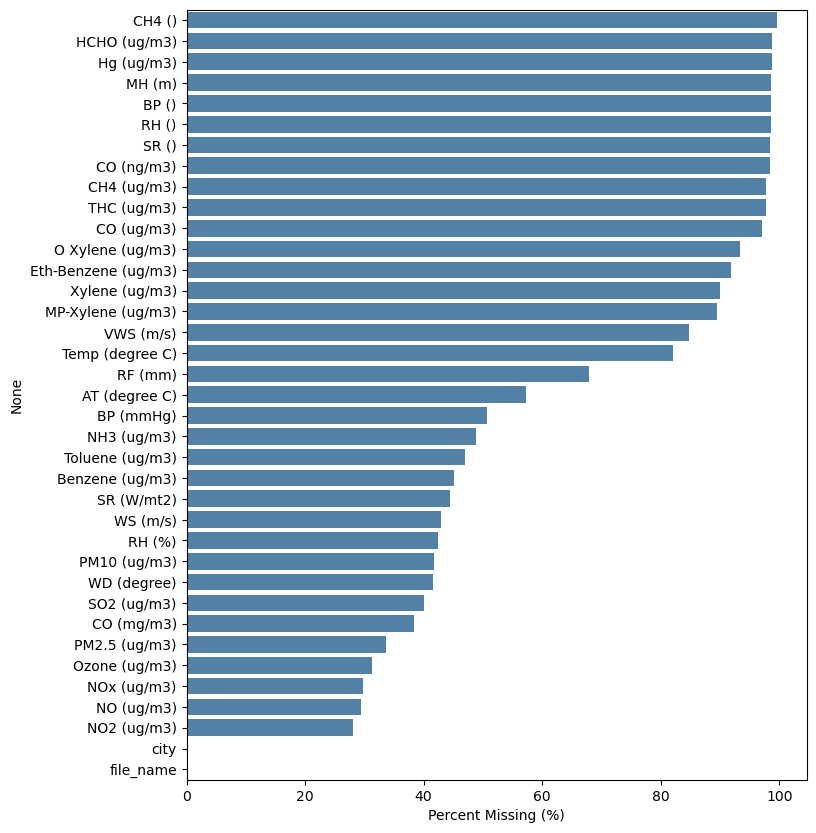

In [63]:
df_null_info = get_null_info(df)
df_null_info.to_csv("nullInfo.csv")

plt.figure(figsize=(8, 10))
sns.barplot(data=df_null_info, x='Percent Missing (%)', y=df_null_info.index, orient='h', color='steelblue')
plt.show()

In [64]:
# Threshold value indicating how much of the dataset needs to be not missing.
threshold = 0.6
df = df.dropna(thresh=df.shape[0]*threshold, axis=1)

In [65]:
df_threshold_not_null_values = get_null_info(df)
df_threshold_not_null_values.to_csv("Remaining_Columns_After_dropping.csv")

In [66]:
pollutants = {
    # A mixture of solid particles and liquid droplets found in the air.
    'Particulate Matter' : ['PM2.5 (ug/m3)', 'PM10 (ug/m3)'],

    # Nitrogen gases form when fuel is burned at high temperatures.
    'Nitrogen Compounds' : ['NOx (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NH3 (ug/m3)'],

    # These are found in coal tar, crude petroleum, paint, vehicle exhausts and industrial emissions.
    'Hydrocarbons' : ['Benzene (ug/m3)', 'Eth-Benzene (ug/m3)', 'Xylene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)', 'Toluene (ug/m3)'],

    # Released from the partial combustion of carbon-containing compounds.
    'Carbon Monoxide': ['CO (mg/m3)'],

    # Released naturally by volcanic activity and is produced as a by-product of copper extraction and the burning of sulfur-bearing fossil fuels.
    'Sulfur Dioxide': ['SO2 (ug/m3)'],

    # It is created mostly the combustion of fossil fuels.
    'Ozone Concentration' : ['Ozone (ug/m3)']
}

other_metrics = {
    # Affects Earth's average temperatures
    'Solar Radiation' : ['SR (W/mt2)'],

    'Temperatures' : ['Temp (degree C)', 'AT (degree C)'],

    'Relative Humidity' : ['RH (%)'],

    'Rainfall' : ['RF (mm)'],

    'Barometric Pressure' : ['BP (mmHg)'],

    'Wind Direction' : ['WD (degree)'],

    'Wind Speed' : ['WS (m/s)']
}

In [67]:
slice_groups = {
    'Group by Day':   df.groupby(pd.Grouper(freq='1D')).mean(numeric_only=True),
    'Group by Month': df.groupby(pd.Grouper(freq='1ME')).mean(numeric_only=True),
    'Group by Year':  df.groupby(pd.Grouper(freq='1YE')).mean(numeric_only=True)
}

In [68]:
def plot_features_by_group(features, slice_groups):    
    for feature in features:
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        fig.suptitle(feature)
        
        labels = []
        for i, (group, group_df) in enumerate(slice_groups.items()):
            data_slice = group_df[group_df.columns.intersection(pollutants[feature])]
            
            # Keep only the NOx feature, as it combines both NO (Nitrogen Oxide) and NO2 (Nitrogen Dioxide)
            if feature == "Nitrogen Compounds":
                data_slice = data_slice.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)
                
            data_slice.plot(kind="line", ax=ax)
            
            for column in data_slice.columns:
                labels.append(f'{column} [{group}]')
        
        ax.set(xlabel=None)
        ax.legend(labels)
        plt.plot()

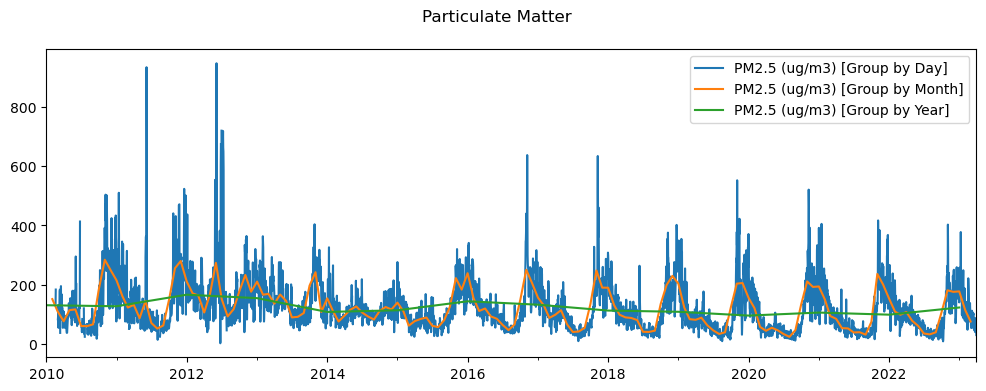

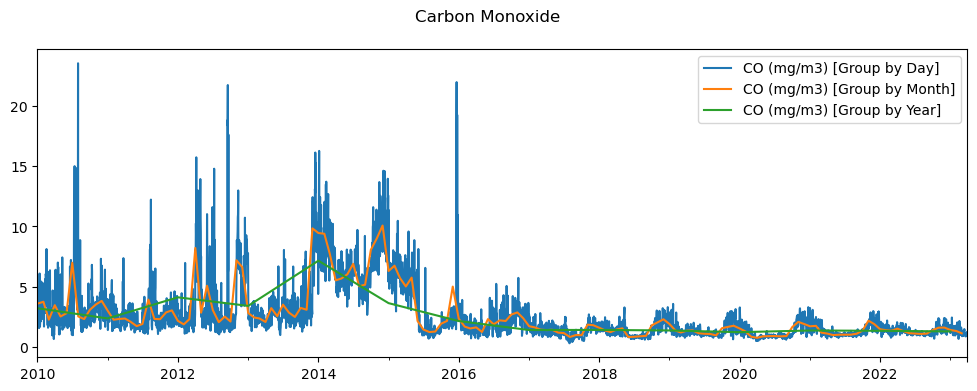

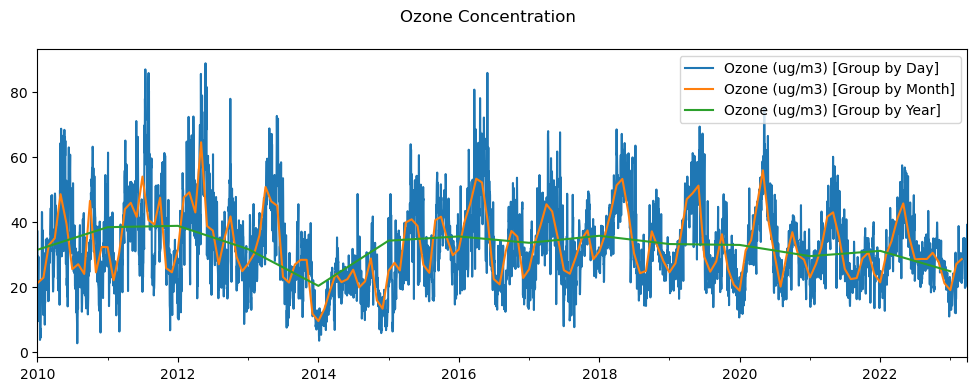

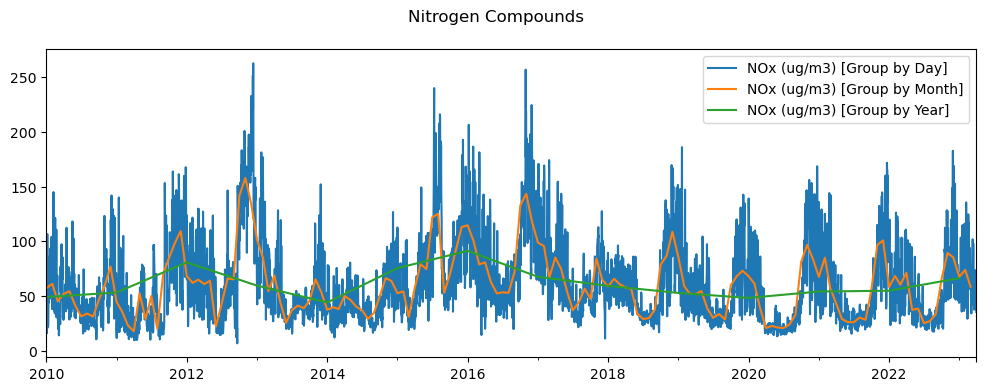

In [69]:
features_to_plot = ['Particulate Matter', 'Carbon Monoxide', 'Ozone Concentration', 'Nitrogen Compounds']
plot_features_by_group(features_to_plot, slice_groups)

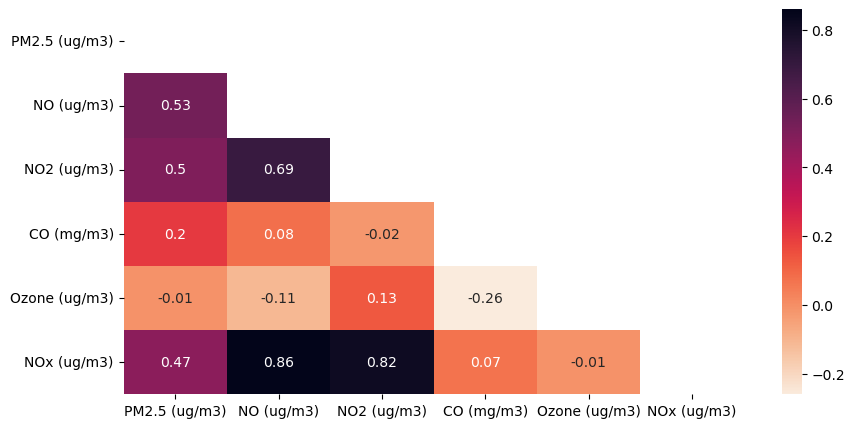

In [70]:
corr = slice_groups['Group by Day'].corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,5))
sns.heatmap(data=corr, mask=mask, annot=True, cmap="rocket_r")
plt.show()

In [73]:
df.drop(['file_name','city'],axis=1,inplace=True)
df.head()

,PM2.5 (ug/m3),NO (ug/m3),NO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),NOx (ug/m3)
datetime,,,,,,
2010-01-01 00:00:00,NaN,21.02,41.00,4.43,3.0,38.75
2010-01-01 01:00:00,NaN,9.12,29.50,3.69,3.5,23.25
2010-01-01 02:00:00,NaN,10.48,27.25,3.68,3.5,23.25
2010-01-01 03:00:00,NaN,6.50,24.25,3.11,4.0,18.25
2010-01-01 04:00:00,NaN,5.75,21.50,2.80,4.0,16.25


In [75]:
df = df.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)

In [76]:
df = df.resample('60min').mean(numeric_only=True)

In [74]:
df.describe()

,PM2.5 (ug/m3),NO (ug/m3),NO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),NOx (ug/m3)
count,1.856276e+06,1.974688e+06,2.012719e+06,1.725199e+06,1.922273e+06,1.962552e+06
mean,1.101011e+02,3.397201e+01,4.339880e+01,1.678117e+00,3.220920e+01,5.668242e+01
std,1.031575e+02,6.322981e+01,4.004954e+01,2.602251e+00,3.449655e+01,7.029215e+01
min,1.000000e-02,1.000000e-02,1.000000e-02,0.000000e+00,1.000000e-02,0.000000e+00
25%,4.125000e+01,4.120000e+00,1.743000e+01,6.700000e-01,8.670000e+00,1.700000e+01
50%,7.750000e+01,9.910000e+00,3.140000e+01,1.100000e+00,1.964000e+01,3.165000e+01
75%,1.451200e+02,3.112000e+01,5.670000e+01,1.800000e+00,4.273000e+01,6.413000e+01
max,1.000000e+03,5.000000e+02,4.999700e+02,5.000000e+01,2.000000e+02,5.000000e+02


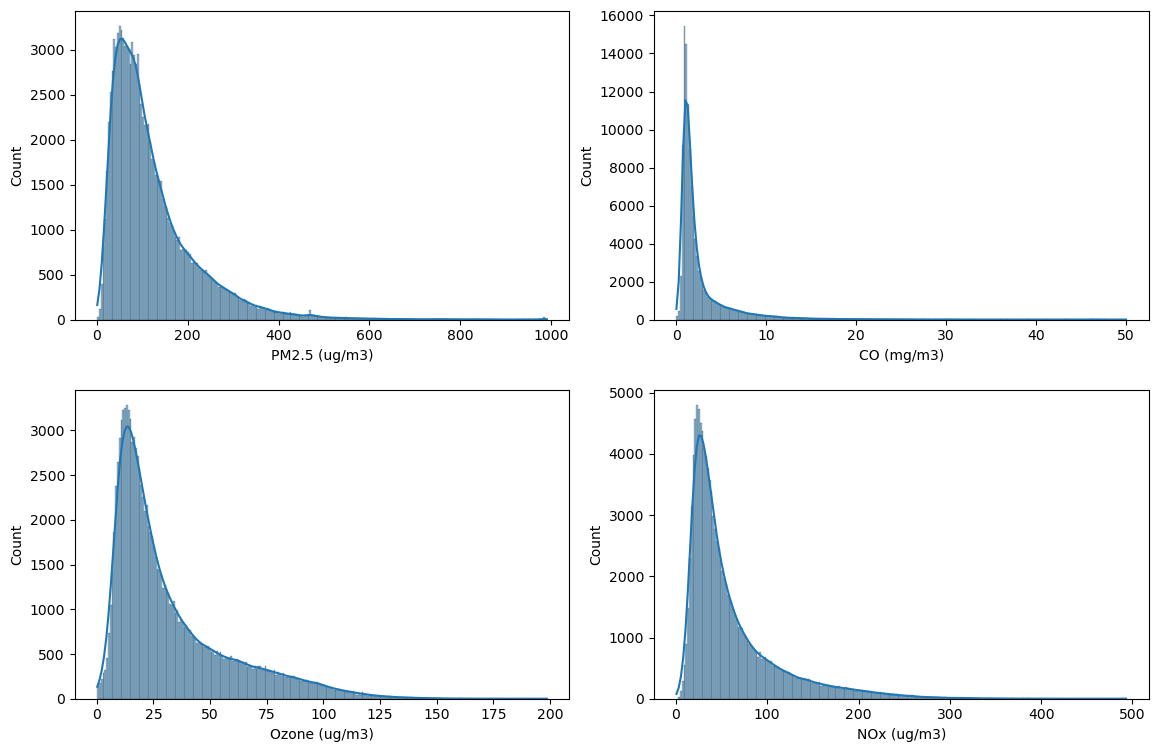

In [77]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(pad=3.0)

sns.histplot(data=df['PM2.5 (ug/m3)'], bins=250, kde=True, ax=axes[0,0])
sns.histplot(data=df['CO (mg/m3)'], bins=250, kde=True, ax=axes[0,1])
sns.histplot(data=df['Ozone (ug/m3)'], bins=250, kde=True, ax=axes[1,0])
sns.histplot(data=df['NOx (ug/m3)'], bins=250, kde=True, ax=axes[1,1])

plt.show()

<Axes: xlabel='datetime'>

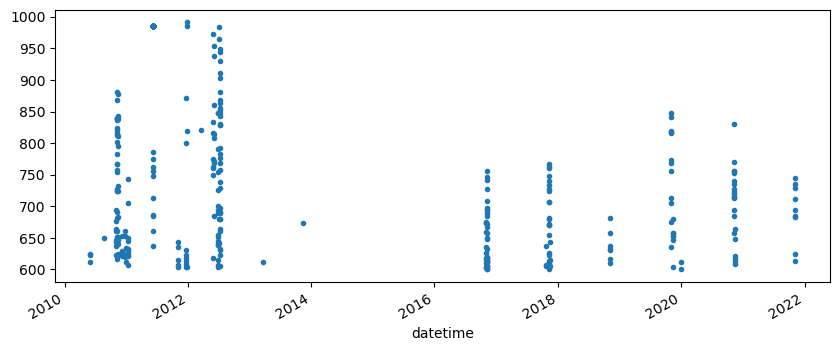

In [78]:
df.query('`PM2.5 (ug/m3)` > 600')['PM2.5 (ug/m3)'].plot(style='.', figsize=(10,4))

In [79]:
df['PM2.5 (ug/m3)'] = df['PM2.5 (ug/m3)'].mask(df['PM2.5 (ug/m3)'].gt(950))

<Axes: xlabel='datetime'>

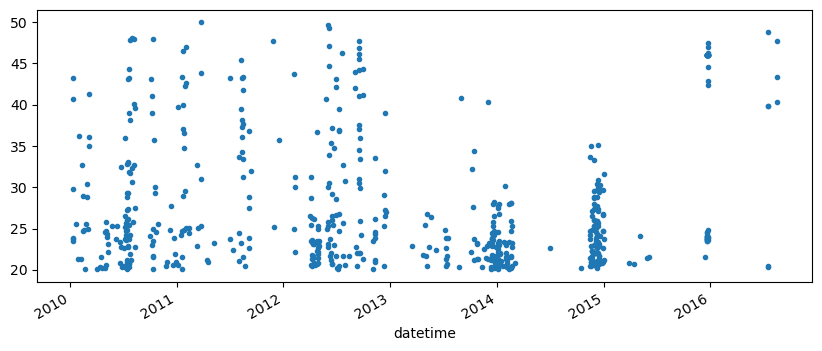

In [80]:
df.query('`CO (mg/m3)` > 20')['CO (mg/m3)'].plot(style='.', figsize=(10,4))

In [81]:
df['CO (mg/m3)'] = df['CO (mg/m3)'].mask(((df.index > '2015') & df['CO (mg/m3)'].gt(35)))

<Axes: xlabel='datetime'>

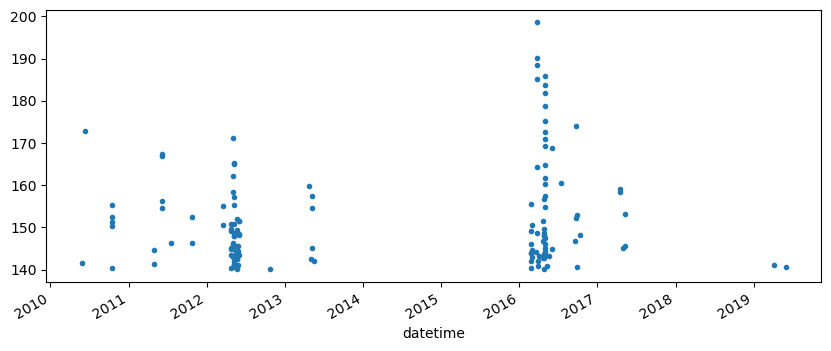

In [82]:
df.query('`Ozone (ug/m3)` > 140')['Ozone (ug/m3)'].plot(style='.', figsize=(10,4))

In [83]:
df['Ozone (ug/m3)'] = df['Ozone (ug/m3)'].mask(df['Ozone (ug/m3)'].gt(185))

<Axes: xlabel='datetime'>

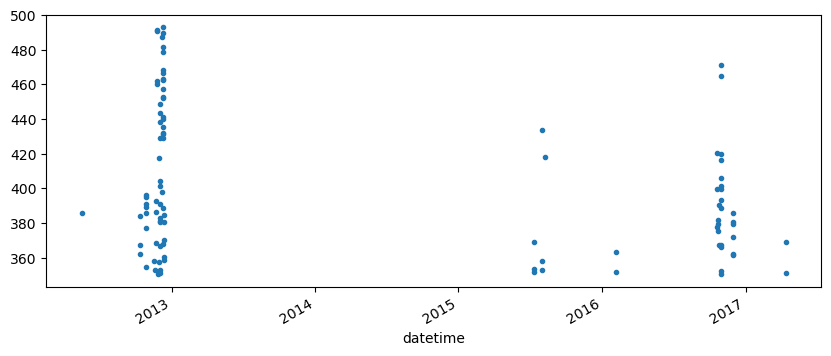

In [84]:
df.query('`NOx (ug/m3)` > 350')['NOx (ug/m3)'].plot(style='.', figsize=(10,4))

In [85]:
df['NOx (ug/m3)'] = df['NOx (ug/m3)'].mask((
    ((df.index < '2013') & (df['NOx (ug/m3)'].gt(380))) |
    ((df.index > '2015') & (df.index < '2016') & (df['NOx (ug/m3)'].gt(400))) |
    ((df.index > '2016') & (df['NOx (ug/m3)'].gt(450)))
))

In [86]:
get_null_info(df)

,Null Count,Percent Missing (%)
PM2.5 (ug/m3),3908,3.37
CO (mg/m3),2123,1.83
NOx (ug/m3),104,0.09
Ozone (ug/m3),67,0.06


In [87]:
df = df.interpolate(method='pad')
df = df.fillna(df.mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116112 entries, 2010-01-01 00:00:00 to 2023-03-31 23:00:00
Freq: 60min
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   PM2.5 (ug/m3)  116112 non-null  float64
 1   CO (mg/m3)     116112 non-null  float64
 2   Ozone (ug/m3)  116112 non-null  float64
 3   NOx (ug/m3)    116112 non-null  float64
dtypes: float64(4)
memory usage: 4.4 MB


/tmp/ipykernel_9553/1820669235.py:1: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.interpolate(method='pad')


In [88]:
def create_features(df):
    df = df.copy()
    df['hour']       = df.index.hour
    df['dayofmonth'] = df.index.day
    df['dayofweek']  = df.index.dayofweek
    df['dayofyear']  = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    df['month']      = df.index.month
    df['quarter']    = df.index.quarter
    df['year']       = df.index.year
    return df

In [89]:
date_features = ['hour', 'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year']
df = create_features(df)

In [90]:
df.head()

,PM2.5 (ug/m3),CO (mg/m3),Ozone (ug/m3),NOx (ug/m3),hour,dayofmonth,dayofweek,dayofyear,weekofyear,month,quarter,year
datetime,,,,,,,,,,,,
2010-01-01 00:00:00,123.404029,2.340000,26.0650,73.7425,0,1,4,1,53,1,1,2010
2010-01-01 01:00:00,123.404029,2.327500,20.3425,36.0000,1,1,4,1,53,1,1,2010
2010-01-01 02:00:00,123.404029,2.177500,11.0650,27.1900,2,1,4,1,53,1,1,2010
2010-01-01 03:00:00,123.404029,1.992500,18.4625,21.1125,3,1,4,1,53,1,1,2010
2010-01-01 04:00:00,123.404029,2.096667,13.7500,23.1550,4,1,4,1,53,1,1,2010


In [92]:
def plot_by_datetime(metric, time_groups):
    for time_group in time_groups:
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)
        ax.set_title(f'{metric} by {time_group}')
        ax.set(xlabel=time_group)
        plt.show()

/tmp/ipykernel_9553/1619461054.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)


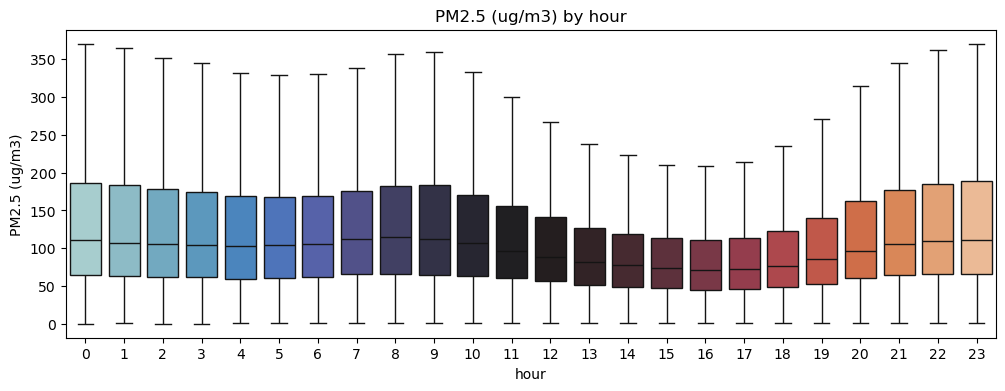

/tmp/ipykernel_9553/1619461054.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)


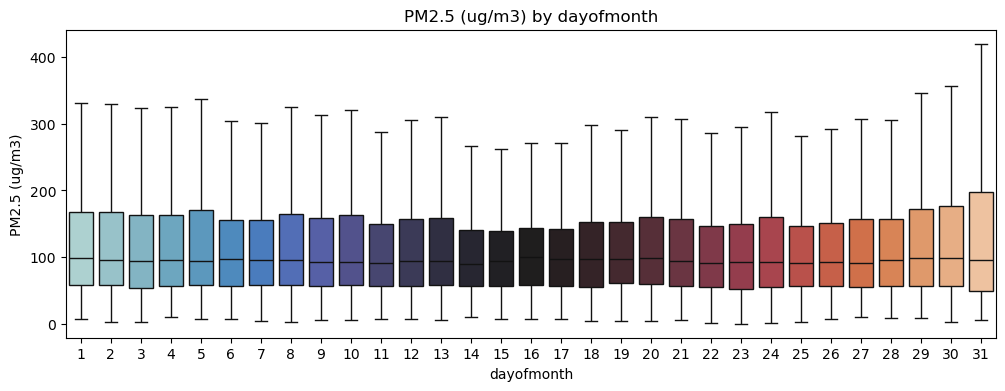

/tmp/ipykernel_9553/1619461054.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)


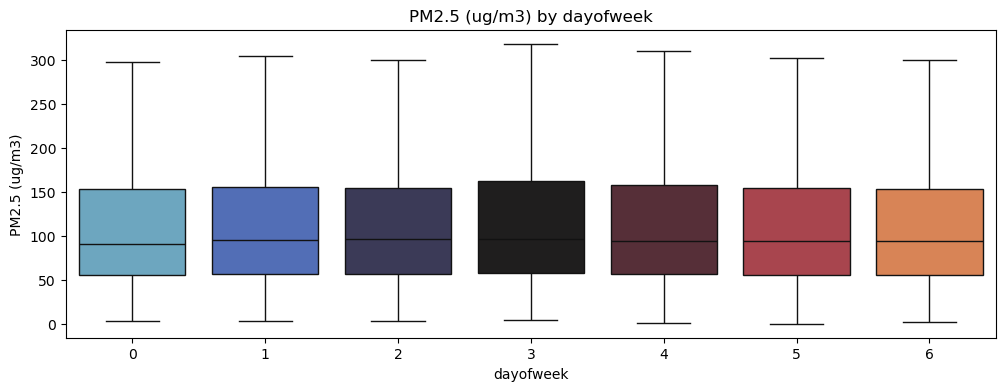

/tmp/ipykernel_9553/1619461054.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)


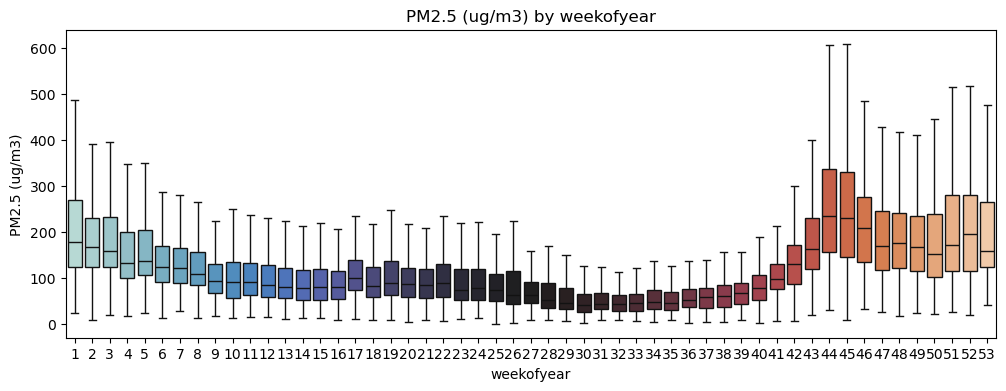

/tmp/ipykernel_9553/1619461054.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)


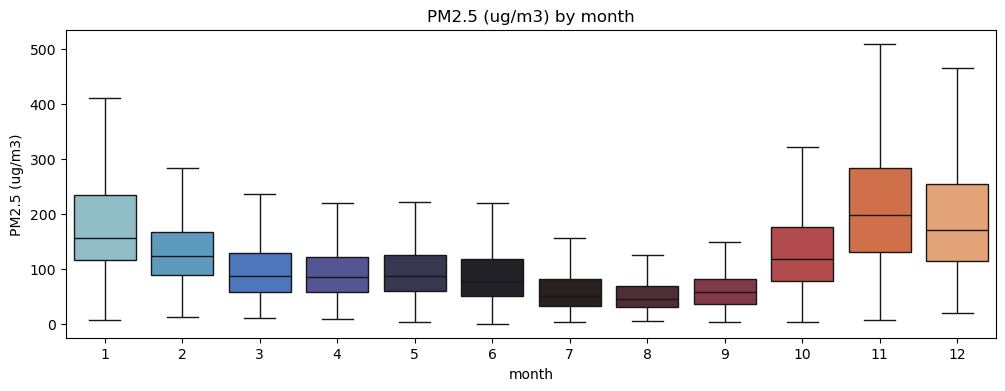

/tmp/ipykernel_9553/1619461054.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)


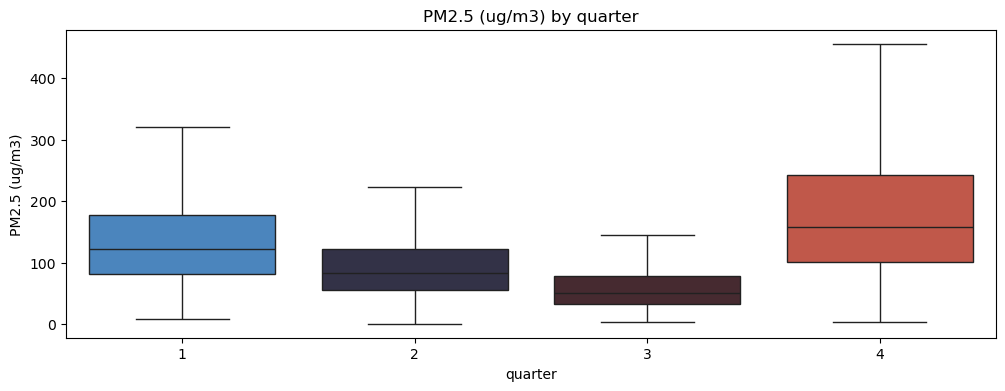

/tmp/ipykernel_9553/1619461054.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)


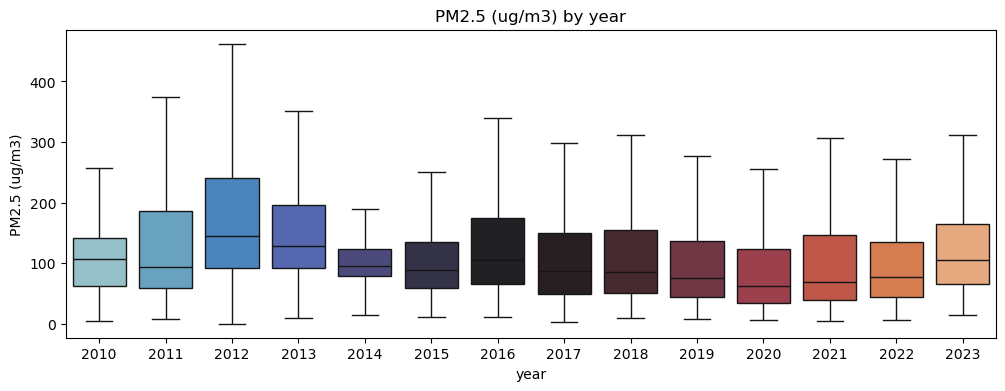

In [93]:
plot_by_datetime('PM2.5 (ug/m3)', ['hour', 'dayofmonth', 'dayofweek', 'weekofyear', 'month', 'quarter', 'year'])

In [94]:
def create_lag_features(df):
    df = df.copy()
    df['pm_lag_1Y'] = df['PM2.5 (ug/m3)'].shift(365*24)   # 1 year lag
    df['pm_lag_2Y'] = df['PM2.5 (ug/m3)'].shift(730*24)   # 2 year lag
    return df

In [95]:
lag_features = ['pm_lag_1Y', 'pm_lag_2Y']
df = create_lag_features(df)
df.head()

,PM2.5 (ug/m3),CO (mg/m3),Ozone (ug/m3),NOx (ug/m3),hour,dayofmonth,dayofweek,dayofyear,weekofyear,month,quarter,year,pm_lag_1Y,pm_lag_2Y
datetime,,,,,,,,,,,,,,
2010-01-01 00:00:00,123.404029,2.340000,26.0650,73.7425,0,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 01:00:00,123.404029,2.327500,20.3425,36.0000,1,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 02:00:00,123.404029,2.177500,11.0650,27.1900,2,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 03:00:00,123.404029,1.992500,18.4625,21.1125,3,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 04:00:00,123.404029,2.096667,13.7500,23.1550,4,1,4,1,53,1,1,2010,NaN,NaN


In [101]:
df.to_csv("aqiFinalCsv.csv")

In [96]:
def replace_lag_na(df, how):
    '''
    Replaces missing values by applying various methods.
    
    Some additional ideas to implement include:
      1. Replace lag NaNs with the overall chosen method for that variable
      2. Replace lag NaNs with the time chosen method for the variable in the window value
    '''

    # Replace lag NaNs with zeros
    if how == 'zeros':
        return df.fillna(0)
    # Drop missing lag records
    if how == 'drop':
        return df.dropna(how='any')

In [97]:
target = 'PM2.5 (ug/m3)'
predictors = date_features + lag_features

In [98]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):
    '''
    Creates the training and testing sets for prediction.

    Parameters
    ----------
        dataframe (DataFrame): The DataFrame to exctract the train and test sets
        split (float): The percentage to split the dataset
        replace_na (bool): Option to replace/remove missing values from the sets
        method (string): The method of dealing with missing values. Options include `zeros` or `drop`

    Return
    ------
        X_train (DataFrame): The training set
        X_test (DataFrame): The testing set
        y_train (Series): The y values of the training set
        y_test (Series): The y values of the testing set
    '''
    
    dataframe = dataframe.copy()
    
    if replace_na:
        dataframe = replace_lag_na(dataframe, how=method)
        
    train_set, test_set = np.split(dataframe, [int(len(df) * split)])
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

In [99]:
X_train, X_test, y_train, y_test = create_train_test_sets(df, split=0.8, replace_na=True, method='drop')

/opt/conda/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [106]:
ensemble_models = {
    'Random Forest':     RandomForestRegressor(random_state=19),
    'Gradient Boosting': GradientBoostingRegressor(random_state=19),
    'AdaBoost':          AdaBoostRegressor(random_state=19),
    'Histogram GB':      HistGradientBoostingRegressor(random_state=19),
    'XGBoost':           xgb.XGBRegressor(random_state=19)
}

In [42]:
df.to_csv("aqiFinalCsv.csv")

In [107]:
def get_estimator_scores(models):
    '''
    Uses various metric algorithms to calculate various scores for multiple estimators
    '''
    metrics = []

    for model_name, model in models.items():            
        model.fit(X_train, y_train)
        predictions_test = model.predict(X_test)
        
        metrics.append([
            model_name,
            model.score(X_train, y_train),
            r2_score(y_test, predictions_test),
            np.sqrt(mean_squared_error(y_test, predictions_test)),
            mean_absolute_error(y_test, predictions_test),
            mean_absolute_percentage_error(y_test, predictions_test)
        ])
    
    return pd.DataFrame(metrics, columns=['model', 'r2_train', 'r2_test', 'rmse', 'mae', 'mape'])

In [108]:
estimator_scores = get_estimator_scores(ensemble_models)

In [109]:
def plot_estimator_scores(scores):
    melted_r2 = scores[['model', 'r2_train', 'r2_test']].rename(columns={"r2_train": "train", "r2_test": "test"})
    melted_r2 = melted_r2.melt(id_vars='model', var_name='set', value_name='score')
        
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.3, wspace=0.4)
    
    sns.barplot(data=melted_r2.round(2), x='score', y='model', hue='set', orient='h', ax=axes[0,0])
    sns.barplot(data=scores.round(2), x='rmse', y='model', orient='h', ax=axes[0,1])
    sns.barplot(data=scores.round(2), x='mae', y='model', orient='h', ax=axes[1,0])
    sns.barplot(data=scores.round(2), x='mape', y='model', orient='h', ax=axes[1,1])
    
    axes[0,0].set_title('R2 Score')
    axes[0,0].bar_label(axes[0,0].containers[0], size=10, padding=5)
    axes[0,0].bar_label(axes[0,0].containers[1], size=10, padding=5)
    axes[0,0].set(xlabel=None, ylabel=None)
    axes[0,0].set_xlim(0, max(melted_r2['score'])+.5)

    axes[0,1].set_title('Root Mean Squared Error')
    axes[0,1].bar_label(axes[0,1].containers[0], size=10, padding=5)
    axes[0,1].set(xlabel=None, ylabel=None)
    axes[0,1].set_xlim(0, max(scores['rmse'])+12)
    
    axes[1,0].set_title('Mean Absolute Error')
    axes[1,0].bar_label(axes[1,0].containers[0], size=10, padding=5)
    axes[1,0].set(xlabel=None, ylabel=None)
    axes[1,0].set_xlim(0, max(scores['mae'])+10)
    
    axes[1,1].set_title('Mean Absolute Percentage Error')
    axes[1,1].bar_label(axes[1,1].containers[0], size=10, padding=5)
    axes[1,1].set(xlabel=None, ylabel=None)
    axes[1,1].set_xlim(0, max(scores['mape'])+0.1)
    
    plt.plot()

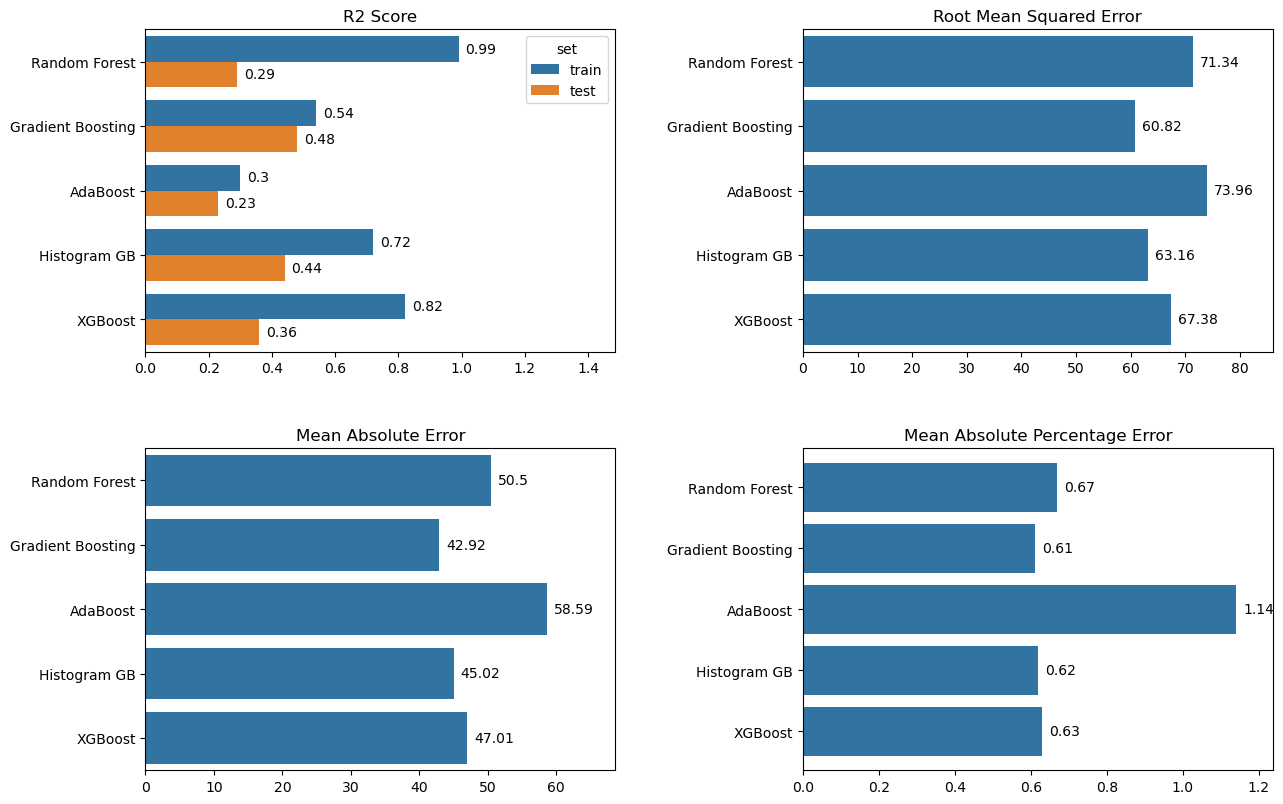

In [110]:
plot_estimator_scores(estimator_scores)

In [113]:
# Hyperparameter configurations for RandomizedSearch
model_hyperparameters = {
    'Random Forest': {'n_estimators': [100,150,200],
                      'min_samples_split': [2,5],
                      'min_samples_leaf': [2,4,10],
                      'max_depth': [5,10],
                      'n_jobs': [-1],
                      'random_state': [19]},
    
    'Gradient Boosting': {'learning_rate': np.arange(0.01,1,0.01),
                          'n_estimators': [100,200,300],
                          'min_samples_split': [2,5],
                          'min_samples_leaf': [1,4,10],
                          'max_depth': [3,5],
                          'n_iter_no_change': [10],
                          'tol': [0.01],
                          'random_state': [19]},
    
    'AdaBoost': {'learning_rate': np.arange(0.01,1,0.01),
                 'n_estimators': [50,100,200,300],
                 'random_state': [19]},
    
    'Histogram GB': {'learning_rate': np.arange(0.01,1,0.01),
                     'max_iter': [100,150,200],
                     'min_samples_leaf': [10,20,30],
                     'max_depth': [None,3,5,10],
                     'n_iter_no_change': [10],
                     'tol': [0.01],
                     'random_state': [19]},
    
    'XGBoost': {'learning_rate': np.arange(0.01,1,0.01),
                'n_estimators': [20,50,100,250],
                'max_depth': [None,3,5],
                'eval_metric': ['rmse'],
                'early_stopping_rounds': [10],
                'n_jobs': [-1],
                'random_state': [19]}
}

In [118]:
def random_search_cv(models, params, n_iter, cv, scoring):
    '''
    Performs hyperparameter tuning using RandomizedSearch.

    Parameters
    ----------
        models (dict): Dictionary containing the name of the model and its respective estimator object.
        params (dict): Dictionary containing the name of the model and its respective hyperparameter spaces to search.
        n_iter (int): The number of candidates to choose from the search space.
        cv (CrossValidator or int): The cross-validation technique. An int value will perform k-fold CV.
        scoring (string): The scoring metric to evaluate the models.

    Return
    ------
        models (dict): A dictionary containing the name of the model and the tuned model parameters.
        model_scores (DataFrame): DataFrame indicating the model's name and the attained best score.
    '''
    
    print(f'Fitting {tscv.n_splits} folds for each of {n_iter} candidates, totalling {tscv.n_splits*n_iter} fits.\n')
    
    model_scores = []

    for model_name, model in ensemble_models.items():
        start = time.time()

        # Use RandomizedSearch as the search space is quite big. For more accurate results we can use GridSearch.
        rscv_model = RandomizedSearchCV(model, params[model_name],
                                        cv=cv,
                                        scoring=scoring,
                                        return_train_score=True,
                                        n_jobs=-1,
                                        n_iter=n_iter,
                                        random_state=19)

        if model_name == 'XGBoost':
            rscv_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)
        else:
            rscv_model.fit(X_train, y_train)
        end = time.time()

        print(f'Randomized Search CV for {model_name} finished after {round(end-start, 2)} seconds. Best parameters found:')
        print(f'{rscv_model.best_params_}\n')

        models[model_name] = rscv_model.best_estimator_
        model_scores.append((model_name, round(-rscv_model.best_score_, 4)))
        
    model_scores = pd.DataFrame(model_scores, columns=['model', 'score'])
    
    return models, model_scores

In [119]:
tscv = TimeSeriesSplit(n_splits=5)
ensemble_models, rscv_scores = random_search_cv(ensemble_models, model_hyperparameters, n_iter=20, cv=tscv, scoring="neg_root_mean_squared_error")

Fitting 5 folds for each of 20 candidates, totalling 100 fits.

Randomized Search CV for Random Forest finished after 326.75 seconds. Best parameters found:
{'random_state': 19, 'n_jobs': -1, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_depth': 5}

Randomized Search CV for Gradient Boosting finished after 316.89 seconds. Best parameters found:
{'tol': 0.01, 'random_state': 19, 'n_iter_no_change': 10, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.05}

Randomized Search CV for AdaBoost finished after 60.55 seconds. Best parameters found:
{'random_state': 19, 'n_estimators': 200, 'learning_rate': 0.8}

Randomized Search CV for Histogram GB finished after 23.98 seconds. Best parameters found:
{'tol': 0.01, 'random_state': 19, 'n_iter_no_change': 10, 'min_samples_leaf': 10, 'max_iter': 100, 'max_depth': 5, 'learning_rate': 0.05}

Randomized Search CV for XGBoost finished after 14.9 seconds. Best parameters

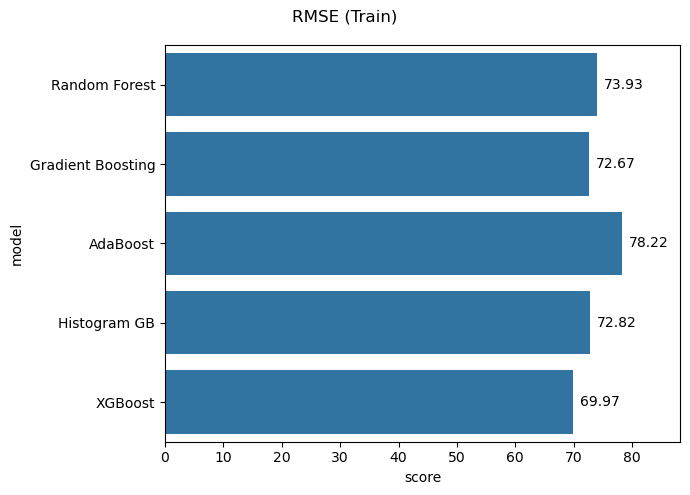

In [120]:
fig = plt.figure(figsize=(7,5))
fig.suptitle("RMSE (Train)")

metrics_plt = sns.barplot(rscv_scores.round(2), x='score', y='model', orient='h')
metrics_plt.tick_params(labelsize=10)
metrics_plt.bar_label(metrics_plt.containers[0], size=10, padding=5)

plt.xlim(0, max(rscv_scores.score)+10)
plt.tight_layout()
plt.show()

In [121]:
time_metrics = []
for model_name, model in ensemble_models.items():
    
    fit_start = time.time()
    if model_name == 'XGBoost':
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)
    else:
        model.fit(X_train, y_train)
    fit_end = time.time()

    pred_start = time.time()
    predictions_test = model.predict(X_test)
    pred_end = time.time()

    time_metrics.append([
        model_name,
        np.sqrt(mean_squared_error(y_test, predictions_test)),
        fit_end-fit_start,
        pred_end-pred_start
    ])
    
time_metrics = pd.DataFrame(time_metrics, columns=['model', 'rmse', 'fit_time', 'predict_time'])

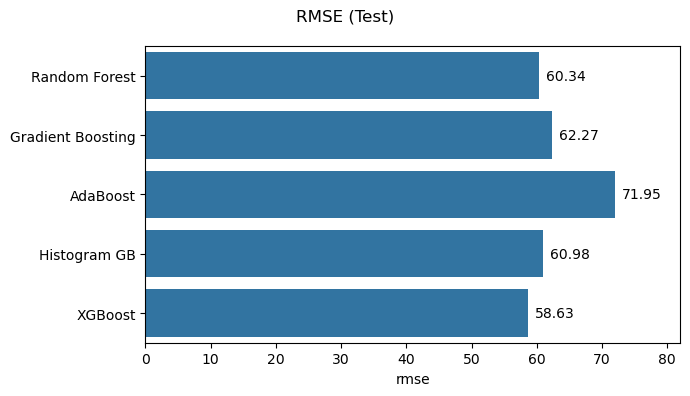

In [122]:
fig = plt.figure(figsize=(7,4))
fig.suptitle("RMSE (Test)")
metrics_plt = sns.barplot(time_metrics.round(2), x='rmse', y='model', orient='h')
metrics_plt.tick_params(labelsize=10)
metrics_plt.bar_label(metrics_plt.containers[0], size=10, padding=5)
metrics_plt.set(ylabel=None)

plt.xlim(0, max(time_metrics.rmse)+10)
plt.tight_layout()
plt.show()

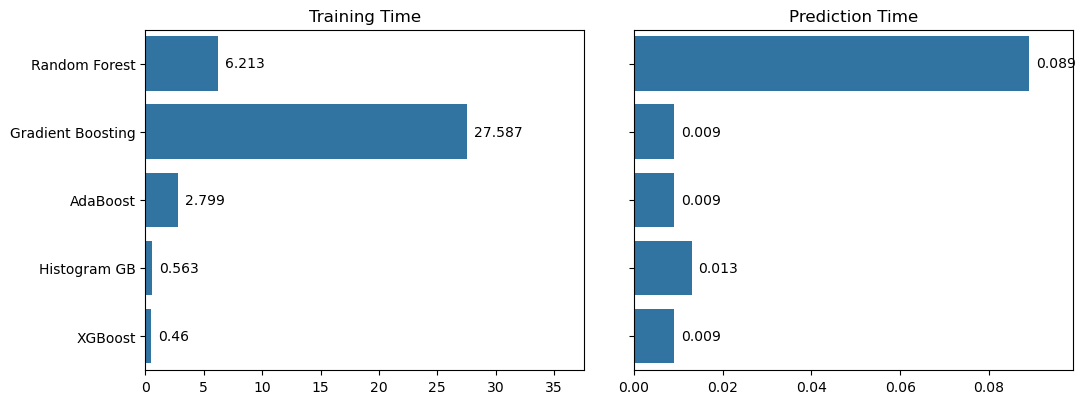

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
fig.tight_layout(w_pad=2.0)

sns.barplot(time_metrics.round(3), x='fit_time', y='model', orient='h', ax=axes[0])
axes[0].bar_label(axes[0].containers[0], size=10, padding=5)
axes[0].set_xlim(0, max(time_metrics.fit_time)+10)
axes[0].set(xlabel=None, ylabel=None)
axes[0].set_title('Training Time')

sns.barplot(time_metrics.round(3), x='predict_time', y='model', orient='h', ax=axes[1])
axes[1].bar_label(axes[1].containers[0], size=10, padding=5)
axes[1].set_xlim(0, max(time_metrics.predict_time)+0.01)
axes[1].set(xlabel=None, ylabel=None)
axes[1].set_title('Prediction Time')

plt.show()